Importing Dependencies

In [12]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

%matplotlib inline
# Suppress warnings
warnings.filterwarnings("ignore")

Auxiliary functions 

In [13]:
def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))

Load data


In [14]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
test_ids = test_raw['PassengerId'].values

# Join data to analyse and process the set as one.
train_raw['train'] = 1
test_raw['train'] = 0
data = train_raw.append(test_raw, sort=False)

Overview the data

In [15]:
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [16]:
data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


One advantage of Bayesian models is that it works well enough with small data, having more would give you more accurate probabilities but it's not data hungry as something like deep learning.

<Axes: >

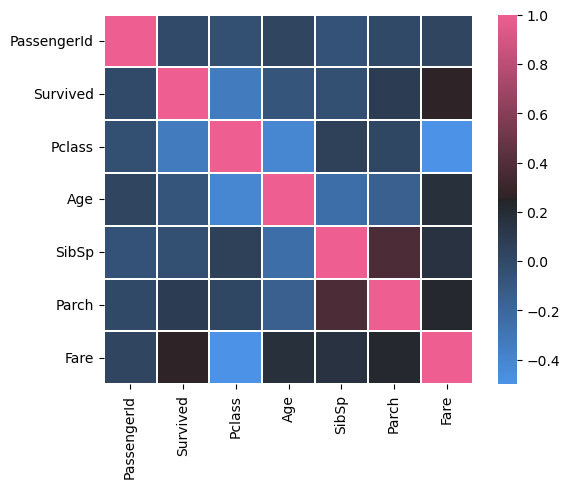

In [17]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

Assumption:
Make a navie assumption that features such as male, class, age, cabin, age, cabin, fare, etc are independent of each other

Pre-process :feature selection, data cleaning, feature engineering and data imputation

In [18]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['train']]
# Categorical values need to be transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'], 10, labels=False)

In [19]:
# Split data into train and test.
train = data.query('train == 1')
test = data.query('train == 0')

# Drop missing values from the train set.
train.dropna(axis=0, inplace=True)
labels = train[target].values

Our processed train set

In [20]:
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2.0,1.0,7.2500,0,3,1,1,0.0,1
1,7.0,2.0,71.2833,0,1,0,1,1.0,1
2,4.0,1.0,7.9250,0,3,0,0,1.0,1
3,6.0,1.0,53.1000,0,1,0,1,1.0,1
4,6.0,1.0,8.0500,0,3,1,0,0.0,1


Correlation study
As we saw Naive Bayes models expect the features to be independent, so let's apply the Pearson correlation coefficient on them to give us a hint about how independent they are from the others.

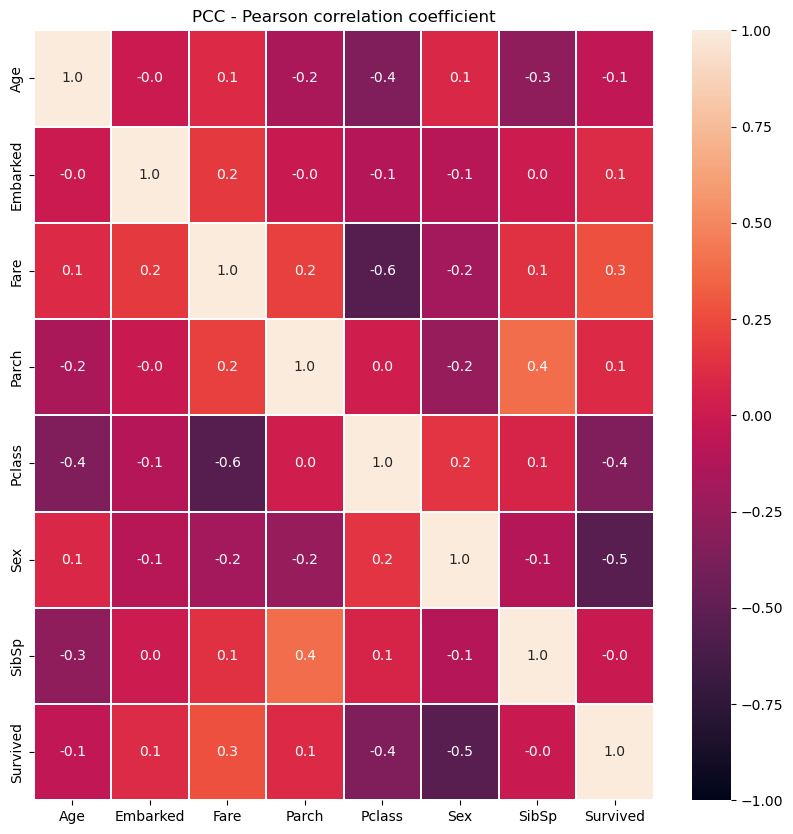

In [22]:
columns = train[features + [target]].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)

# Apply Pearson correlation on each pair of features.
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = pearsonr(train.loc[:, columns[col_a]], train.loc[:,  columns[col_b]])[0]
        
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1, annot=True, fmt='.1f', linewidths=.2)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

Distribution study

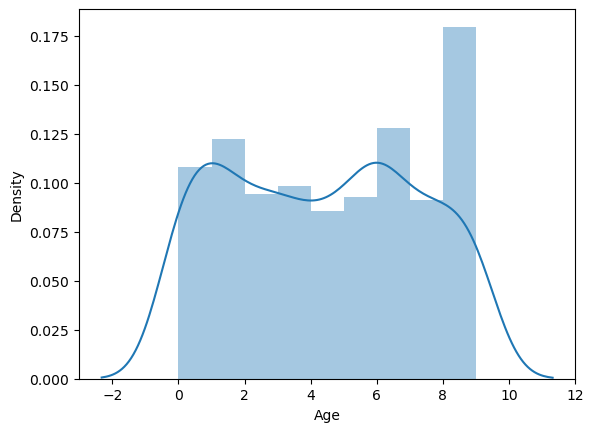

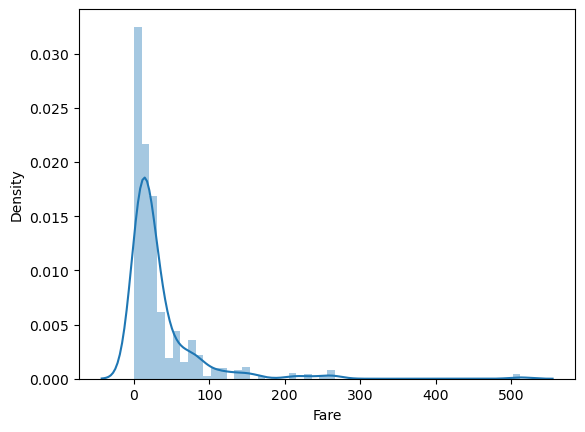

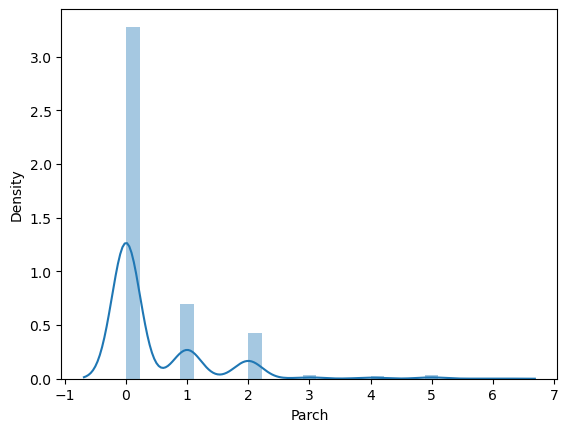

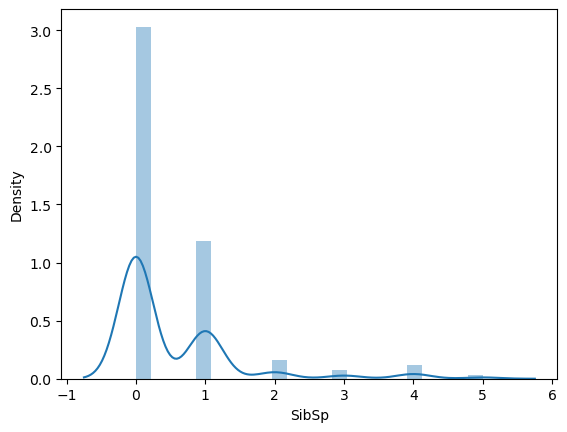

In [23]:
continuous_numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
for feature in continuous_numeric_features:
    sns.distplot(train[feature])
    plt.show()

Looking at our continuous numeric features we can see that "Fare", "Parch" and "SibSp", have a distribution close to normal, but with a left side skew, "Age" have a distribution a a bit different from the other but maybe it's close enough to Gaussian

In [24]:
train.drop(['train', target, 'Pclass'], axis=1, inplace=True)
test.drop(['train', target, 'Pclass'], axis=1, inplace=True)

Split data in train and validation (80% ~ 20%)

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

In [27]:
X_train.head()

,Age,Embarked,Fare,Parch,Sex,SibSp
830,1.0,2.0,14.4542,0,0,1
566,1.0,1.0,7.8958,0,1,0
149,7.0,1.0,13.0000,0,1,0
106,2.0,1.0,7.6500,0,0,0
290,4.0,1.0,78.8500,0,0,0


Split train data into two parts

In [28]:
X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train, Y_train, test_size=0.3, random_state=12)

Naive Bayes classifier

In [29]:
classifier = GaussianNB()

Fit the first part

In [30]:
classifier.fit(X_train2, Y_train2)


GaussianNB()

In [31]:
print('Metrics with only 30% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with only 30% of train data
Model metrics
Accuracy  Train: 0.79, Validation: 0.76
Recall    Train: 0.75, Validation: 0.71
Precision Train: 0.71, Validation: 0.71


Update the model with the second part

In [32]:
classifier.partial_fit(X_train1, Y_train1)

GaussianNB()

In [33]:
print('Metrics with the remaining 70% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with the remaining 70% of train data
Model metrics
Accuracy  Train: 0.80, Validation: 0.76
Recall    Train: 0.78, Validation: 0.70
Precision Train: 0.69, Validation: 0.69


As we can see our results improved after we updated the model with the remaining data.

In [34]:
print('Probability of each class')
print('Survive = 0: %.2f' % classifier.class_prior_[0])
print('Survive = 1: %.2f' % classifier.class_prior_[1])

Probability of each class
Survive = 0: 0.60
Survive = 1: 0.40


In [35]:
print('Mean of each feature per class')
print('               Age         Embarked   Fare         Parch       Sex         SibSp')
print('Survive = 0: %s' % classifier.theta_[0])
print('Survive = 1: %s' % classifier.theta_[1])


Mean of each feature per class
               Age         Embarked   Fare         Parch       Sex         SibSp
Survive = 0: [ 4.5339233   1.23893805 22.97357316  0.37463127  0.86135693  0.5280236 ]
Survive = 1: [ 4.27391304  1.33478261 53.52155957  0.52608696  0.33043478  0.49130435]


Apply the model on the test data and create submission

In [39]:
# Unfortunately sklearn naive Bayes algorithm currently do not make inference with missing data (but should do), so we need to input missing data.
test.fillna(test.mean(), inplace=True)
test_predictions = classifier.predict(test)
submission = pd.DataFrame({'PassengerId': test_ids})
submission['Survived'] = test_predictions.astype('int')
submission.to_csv('submission.csv', index=False)
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
